In [1]:
import argparse
import re
import os, glob, datetime
import numpy as np
from keras.layers import  Input,Conv2D,BatchNormalization,Activation,Subtract
from keras.models import Model, load_model
from keras.callbacks import CSVLogger, ModelCheckpoint, LearningRateScheduler
from keras.optimizers import Adam
import data_generator as dg
import keras.backend as K

Using TensorFlow backend.


In [2]:
import sys
sys.path.append("./Func")
from editing_network import NetworkEdit_base

In [3]:
def DnCNN(depth,filters=64,image_channels=1, use_bnorm=True):
    layer_count = 0
    inpt = Input(shape=(None,None,image_channels),name = 'input'+str(layer_count))
    # 1st layer, Conv+relu
    layer_count += 1
    x = Conv2D(filters=filters, kernel_size=(3,3), strides=(1,1),kernel_initializer='Orthogonal', padding='same',name = 'conv'+str(layer_count))(inpt)
    layer_count += 1
    x = Activation('relu',name = 'relu'+str(layer_count))(x)
    # depth-2 layers, Conv+BN+relu
    for i in range(depth-2):
        layer_count += 1
        x = Conv2D(filters=filters, kernel_size=(3,3), strides=(1,1),kernel_initializer='Orthogonal', padding='same',use_bias = False,name = 'conv'+str(layer_count))(x)
        if use_bnorm:
            layer_count += 1
            #x = BatchNormalization(axis=3, momentum=0.1,epsilon=0.0001, name = 'bn'+str(layer_count))(x) 
        x = BatchNormalization(axis=3, momentum=0.0,epsilon=0.0001, name = 'bn'+str(layer_count))(x)
        layer_count += 1
        x = Activation('relu',name = 'relu'+str(layer_count))(x)  
    # last layer, Conv
    layer_count += 1
    x = Conv2D(filters=image_channels, kernel_size=(3,3), strides=(1,1), kernel_initializer='Orthogonal',padding='same',use_bias = False,name = 'conv'+str(layer_count))(x)
    layer_count += 1
    x = Subtract(name = 'subtract' + str(layer_count))([inpt, x])   # input - noise
    model = Model(inputs=inpt, outputs=x)
    
    return model

In [4]:
def lr_schedule(epoch):
    initial_lr = 1e-3
    if epoch<=30:
        lr = initial_lr
    elif epoch<=60:
        lr = initial_lr/10
    elif epoch<=80:
        lr = initial_lr/20 
    else:
        lr = initial_lr/20 
    print('current learning rate is %2.8f' %lr)
    return lr

In [5]:
def train_datagen(epoch_iter=2000,epoch_num=5,batch_size=128,data_dir="/data/BSDS300/images/train/"):
    while(True):
        n_count = 0
        if n_count == 0:
            #print(n_count)
            xs = dg.datagenerator(data_dir)
            assert len(xs)%batch_size ==0, \
            log('make sure the last iteration has a full batchsize, this is important if you use batch normalization!')
            xs = xs.astype('float32')/255.0
            indices = list(range(xs.shape[0]))
            n_count = 1
        for _ in range(epoch_num):
            np.random.shuffle(indices)    # shuffle
            for i in range(0, len(indices), batch_size):
                batch_x = xs[indices[i:i+batch_size]]
                noise =  np.random.normal(0, np.random.rand()*50/255.0, batch_x.shape)    # noise
                #noise =  K.random_normal(ge_batch_y.shape, mean=0, stddev=args.sigma/255.0)
                batch_y = batch_x + noise 
                yield batch_y, batch_x

In [6]:
# data_dir="/data/BSDS300/images/train/"
# xg = dg.datagenerator(data_dir)

In [7]:
# print(xg.shape)

In [8]:
def sum_squared_error(y_true, y_pred):
    #return K.mean(K.square(y_pred - y_true), axis=-1)
    #return K.sum(K.square(y_pred - y_true), axis=-1)/2
    return K.sum(K.square(y_pred - y_true))/2

In [9]:
model = DnCNN(depth=17,filters=64,image_channels=1,use_bnorm=True)
from keras.utils import multi_gpu_model
model = multi_gpu_model(model, gpus=2)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input0 (InputLayer)             (None, None, None, 1 0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, None, None, 1 0           input0[0][0]                     
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, None, None, 1 0           input0[0][0]                     
__________________________________________________________________________________________________
model_1 (Model)                 (None, None, None, 1 558016      lambda_1[0][0]                   
                                                                 lambda_2[0][0]                   
__________

In [10]:
model.compile(optimizer=Adam(0.001), loss=sum_squared_error)
lr_scheduler = LearningRateScheduler(lr_schedule)

In [11]:
history = model.fit_generator(train_datagen(batch_size=128),
            steps_per_epoch=2000, epochs=100, verbose=1, initial_epoch=0,
            callbacks=[lr_scheduler])

current learning rate is 0.00100000
Epoch 1/100
^_^-training data finished-^_^
2000/2000 [==============================] - 188s 94ms/step - loss: 499.2024
current learning rate is 0.00100000
Epoch 2/100
2000/2000 [==============================] - 181s 91ms/step - loss: 237.3593
current learning rate is 0.00100000
Epoch 3/100
2000/2000 [==============================] - 182s 91ms/step - loss: 220.8591
current learning rate is 0.00100000
Epoch 4/100
2000/2000 [==============================] - 182s 91ms/step - loss: 212.7277
current learning rate is 0.00100000
Epoch 5/100
2000/2000 [==============================] - 181s 91ms/step - loss: 226.5712
current learning rate is 0.00100000
Epoch 6/100
2000/2000 [==============================] - 182s 91ms/step - loss: 198.2651
current learning rate is 0.00100000
Epoch 7/100
2000/2000 [==============================] - 181s 90ms/step - loss: 185.7344
current learning rate is 0.00100000
Epoch 8/100
2000/2000 [==============================] - 1

2000/2000 [==============================] - 182s 91ms/step - loss: 147.8156
current learning rate is 0.00005000
Epoch 63/100
2000/2000 [==============================] - 181s 91ms/step - loss: 146.0398
current learning rate is 0.00005000
Epoch 64/100
2000/2000 [==============================] - 181s 91ms/step - loss: 148.3362
current learning rate is 0.00005000
Epoch 65/100
2000/2000 [==============================] - 182s 91ms/step - loss: 150.0026
current learning rate is 0.00005000
Epoch 66/100
2000/2000 [==============================] - 181s 91ms/step - loss: 146.0837
current learning rate is 0.00005000
Epoch 67/100
2000/2000 [==============================] - 182s 91ms/step - loss: 148.1731
current learning rate is 0.00005000
Epoch 68/100
2000/2000 [==============================] - 183s 91ms/step - loss: 147.2921
current learning rate is 0.00005000
Epoch 69/100
2000/2000 [==============================] - 183s 91ms/step - loss: 143.7373
current learning rate is 0.00005000
Epoch

In [13]:
save_path = "./saved_model/"
model_name = "fullmodel_100.h5"
model_architecture = "model_architecture_100.json"
model_weights = "model_weights_100.h5"
my_model = NetworkEdit_base(model=model)
my_model.SaveModel(save_content="MODEL", save_path=save_path, save_filename=model_name)
my_model.SaveModel(save_content="ARCHITECTURE", save_path=save_path, save_filename=model_architecture)
my_model.SaveModel(save_content="WEIGHTS", save_path=save_path, save_filename=model_weights)

TypeError: cannot serialize '_io.FileIO' object

In [14]:
import glob 
filelist = glob.glob("/data/BSDS300/images/test/"+'/*.jpg')

In [15]:
import cv2
test_img = cv2.imread(filelist[0],0)

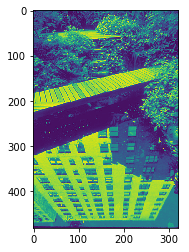

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(test_img)

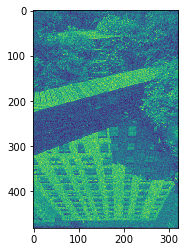

In [20]:
noise_level = 30
img = test_img/255.0
noise =  np.random.normal(0, noise_level/255.0, test_img.shape)
noisy_img = img+noise
plt.imshow(noisy_img)

In [ ]:
model_input = np.reshape(noisy_img,(1,*noisy_img.shape,1))
print(model_input.shape)
y_predict = model.predict(model_input)
print(y_predict.shape)